In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from simple_detector import *
from advanced_detector import CameraPipeline
from imageio import imwrite 

In [3]:
import logging
logging.basicConfig()
format_ = '%(asctime) - %(message)s'
logger = logging.getLogger('test')
logger.setLevel(logging.DEBUG)

In [4]:
# calibration n test cases
calibration_folder = 'camera_cal'
test_cases = 'test_images'

# Testing

In [5]:
from advanced_detector import hls_select
test_set = glob.glob(test_cases + '/*.jpg')

# Filtering

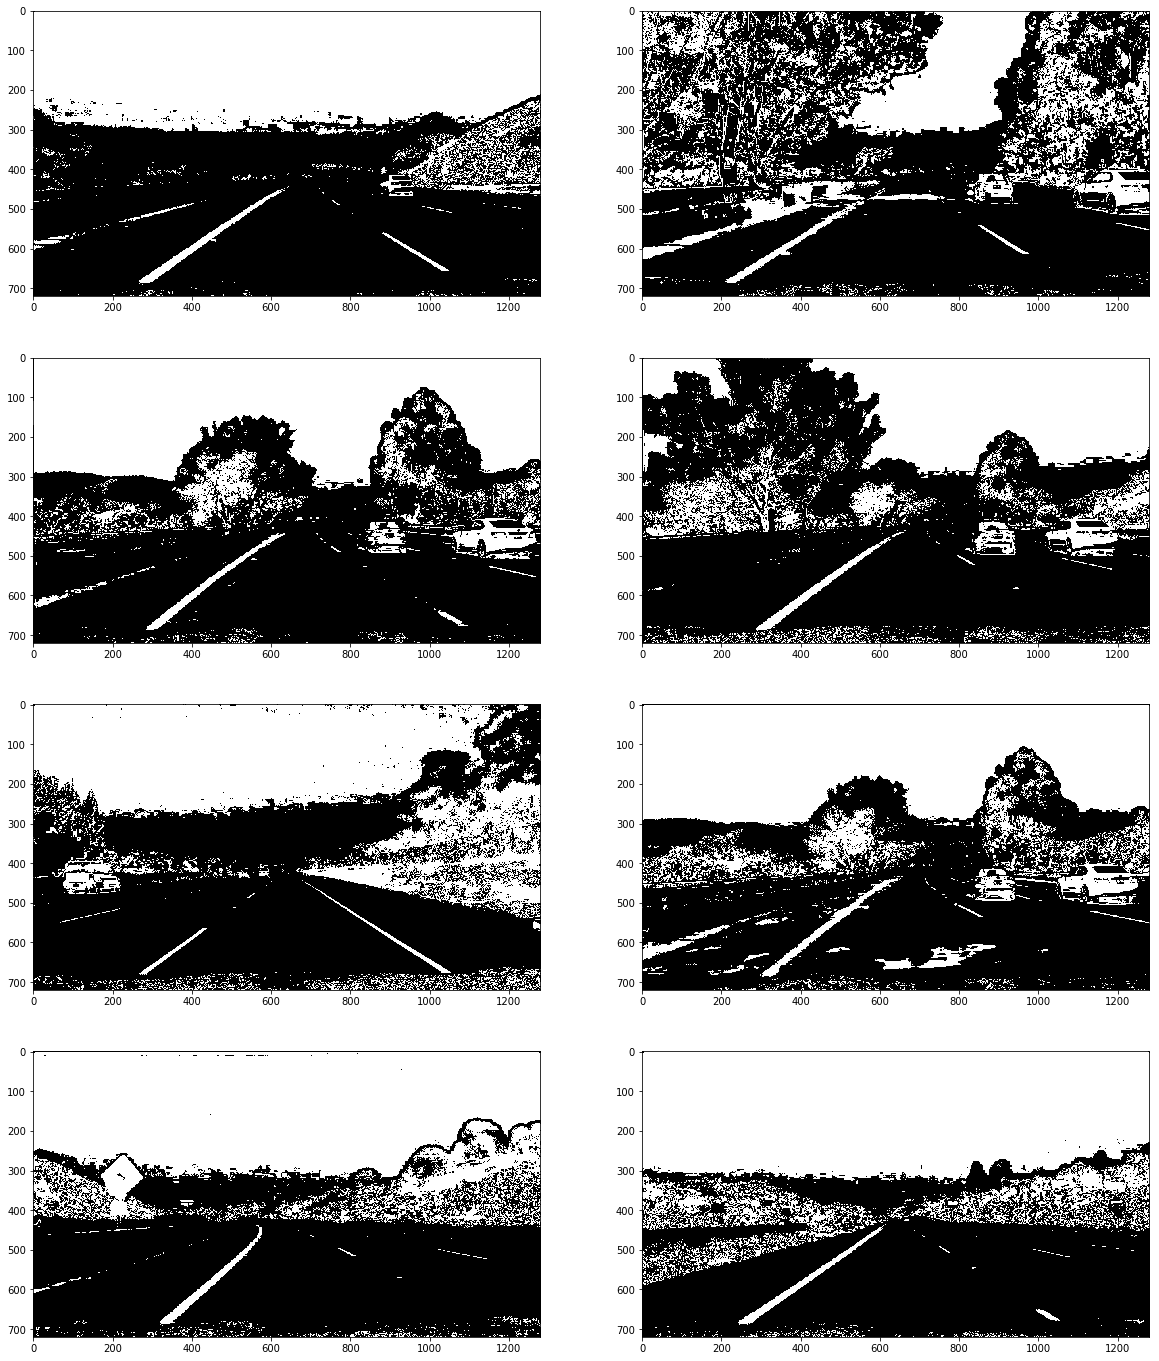

In [6]:
# check filtering
from advanced_detector import filter_image

test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
for i in range(0, test_length):

    img_name = test_set[i].split('/')[1]
    
    img, img_size = read_video(test_set[i])
    
    merg = filter_image(img)
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(merg, cmap='gray', interpolation='none')
    
    savepath = os.path.join('output_images', 'filtered' + img_name)

# Pipeline Development

Testing pipeline to work out how to perspective transform image

In [7]:
def testing_pipeline(img_path, how_far_down):
    
    result, fr_shape = read_video(img_path)
    
    hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    
    #proc_f = grayscale(result)
    proc_f = gaussian_blur(S, 5)
    proc_f = canny(proc_f, 30, 255)
    roi = region_of_interest(proc_f, np.array([[(0.1*fr_shape[1],fr_shape[0]),
                                            (fr_shape[1]*0.95, fr_shape[0]), 
                                            (0.55*fr_shape[1], how_far_down*fr_shape[0]), 
                                            (0.45*fr_shape[1],how_far_down*fr_shape[0])]], dtype=np.int32))
    proc_f_lines = hough_lines(roi, 4, np.pi/180, 16, 5, 400)
    if proc_f_lines is not None:
        final_lines = find_lines(proc_f, proc_f_lines)
        #logger.debug('{0} lines'.format(final_lines))
    
        corner_points = find_points_for_transform(final_lines, result)
        logger.debug('image:{0} corner points:{1}'.format(img_path, corner_points))
        
        output_img = draw_lines(proc_f, final_lines, margin = 90)
        output_img = weighted_img(output_img, result)

    else:
        output_img = result
        
    return output_img, corner_points

DEBUG:test:image:test_images/test5.jpg corner points:[[227, 687, 585, 468], [910, 574, 973, 613]]


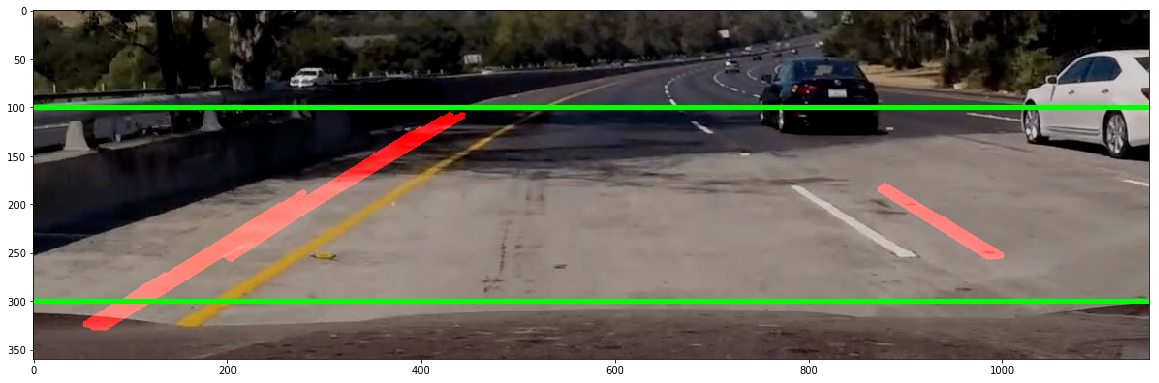

In [8]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
side_margin = 0.05
for i in range(1, 2):

    output_img, corners = testing_pipeline(test_set[i], hfd)
    
    output_shape = output_img.shape
    
    car_forward_region = output_img[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
    
    # drawing some lines to find an ideal crop to take to create the perspective warp
    cv2.line(car_forward_region, (0,100),(car_forward_region.shape[1],100),[0,255,0], 3)
    cv2.line(car_forward_region, (0,300),(car_forward_region.shape[1],300),[0,255,0], 3)
    
    #plt.subplot(test_length,2,i+1)
    plt.imshow(car_forward_region, cmap='gray', interpolation='none')

In [9]:
# it's not working right but lets do the perspective transform and other bits first
img_size = car_forward_region.shape

src = np.float32([[445, 150], [760, 150], [150,300], [1100,300]])
dst = np.float32([[190, 150], [1055, 150], [150,300], [1100,300]])

In [10]:
# hardcoded perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(car_forward_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR) 

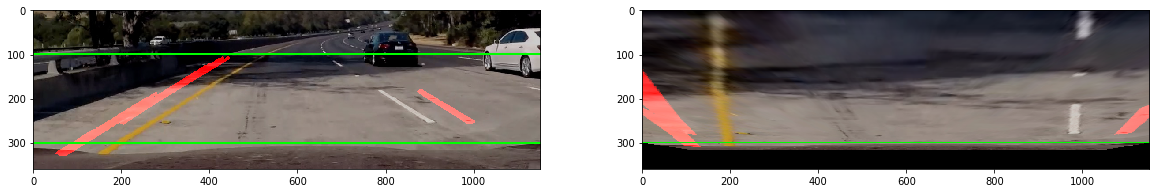

In [11]:
plt.figure(figsize=(20,50))
plt.subplot(1,2,1)
plt.imshow(car_forward_region, cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(warped, cmap='gray') 

In [12]:
from imageio import imwrite
imwrite(os.path.join('output_images', 'prewarp.jpg'), car_forward_region)
imwrite(os.path.join('output_images', 'postwarp.jpg'), warped)

# Distort and run the window on merged image

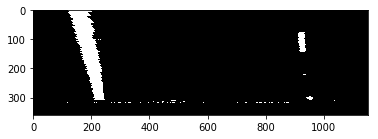

In [13]:
merged_car_region = merg[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
img_size = merged_car_region.shape
warped = cv2.warpPerspective(merged_car_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 

In [14]:
# try exercise code
from advanced_detector import find_lane_pixels, fit_polynomial, measure_curvature_pixels, calc_bias

In [15]:
left_fit, right_fit, left_fit_pts, right_fit_pts, ploty = fit_polynomial(warped, None, None)
#plt.imshow(out_img)

In [16]:
type(left_fit)

numpy.ndarray

### Curvature & Offset Calcs

In [17]:
left_curve, right_curve = measure_curvature_pixels(warped, left_fit, right_fit)

In [18]:
print('left curve: {0}, right curve: {1}'.format(left_curve, right_curve) )

left curve: 1708.2434458882992, right curve: 1986.8406308647145


In [19]:
bias = calc_bias(warped, left_fit_pts, right_fit_pts)
print('bias (-ve is right drift): {:.2f}m'.format(bias))

bias (-ve is right drift): -0.23m


# Calibrate Image First

In [39]:
cal_images = glob.glob(calibration_folder + '/*.jpg')

In [40]:
process_cam = CameraPipeline(9,6)
process_cam.calibrate_cam(cal_images)

In [41]:
test_set

['test_images/test3.jpg',
 'test_images/test5.jpg',
 'test_images/test1.jpg',
 'test_images/test6.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test4.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines1.jpg']

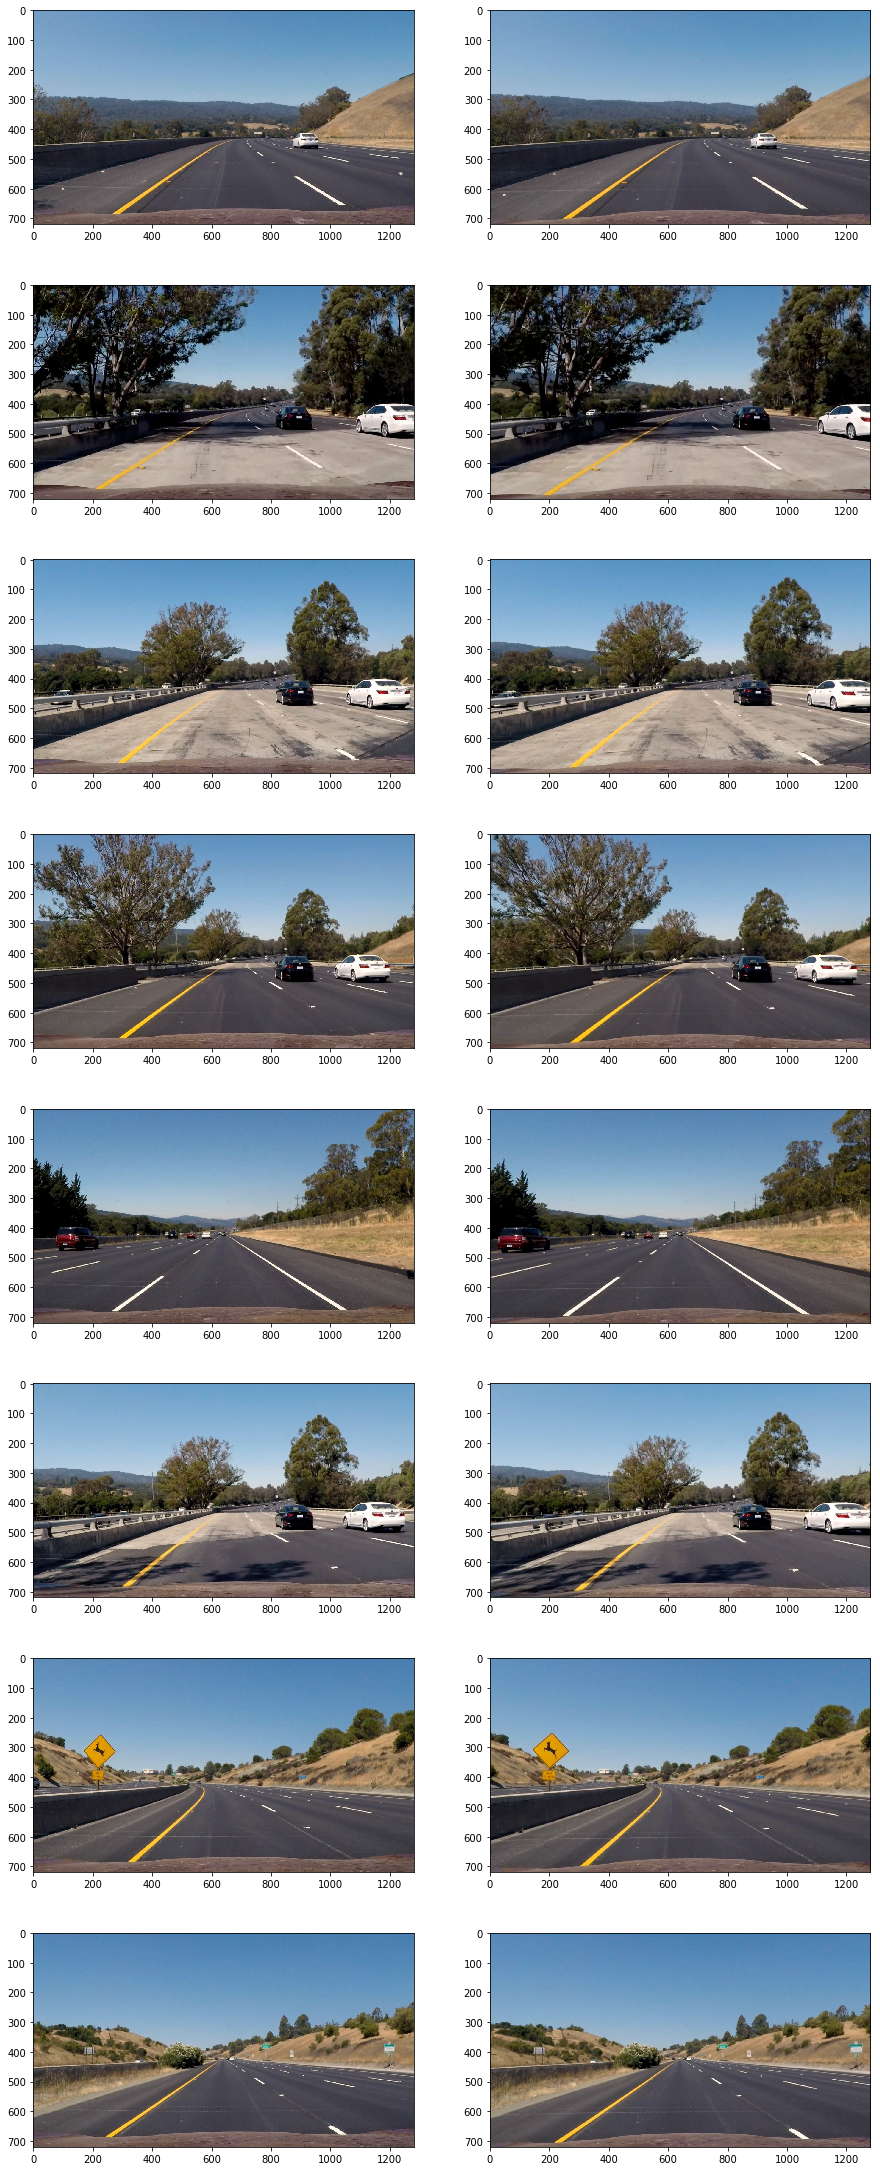

In [42]:
from advanced_detector import undistort_img
# test the calibration by undistorting
test_length = len(test_set)
plt.figure(figsize=(15,80))
for i in range(0, test_length):
    #logger.info(print(test_pack[i]))
    img_name = test_set[i].split('/')[1]
    
    img, size = read_video(test_set[i])
    result = undistort_img(img, process_cam.objpoints, process_cam.imgpoints)    
    
    plt.subplot(test_length*2,2,i*2+1)
    plt.imshow(img, interpolation='none')
    plt.subplot(test_length*2,2,i*2+2)
    plt.imshow(result, interpolation='none')
    
    # name
    #output_name = 'undist_' + img_name
    #savepath = os.path.join('output_images', output_name)
    
    #cv2.imwrite(savepath, result.astype(np.uint8))

# Filter

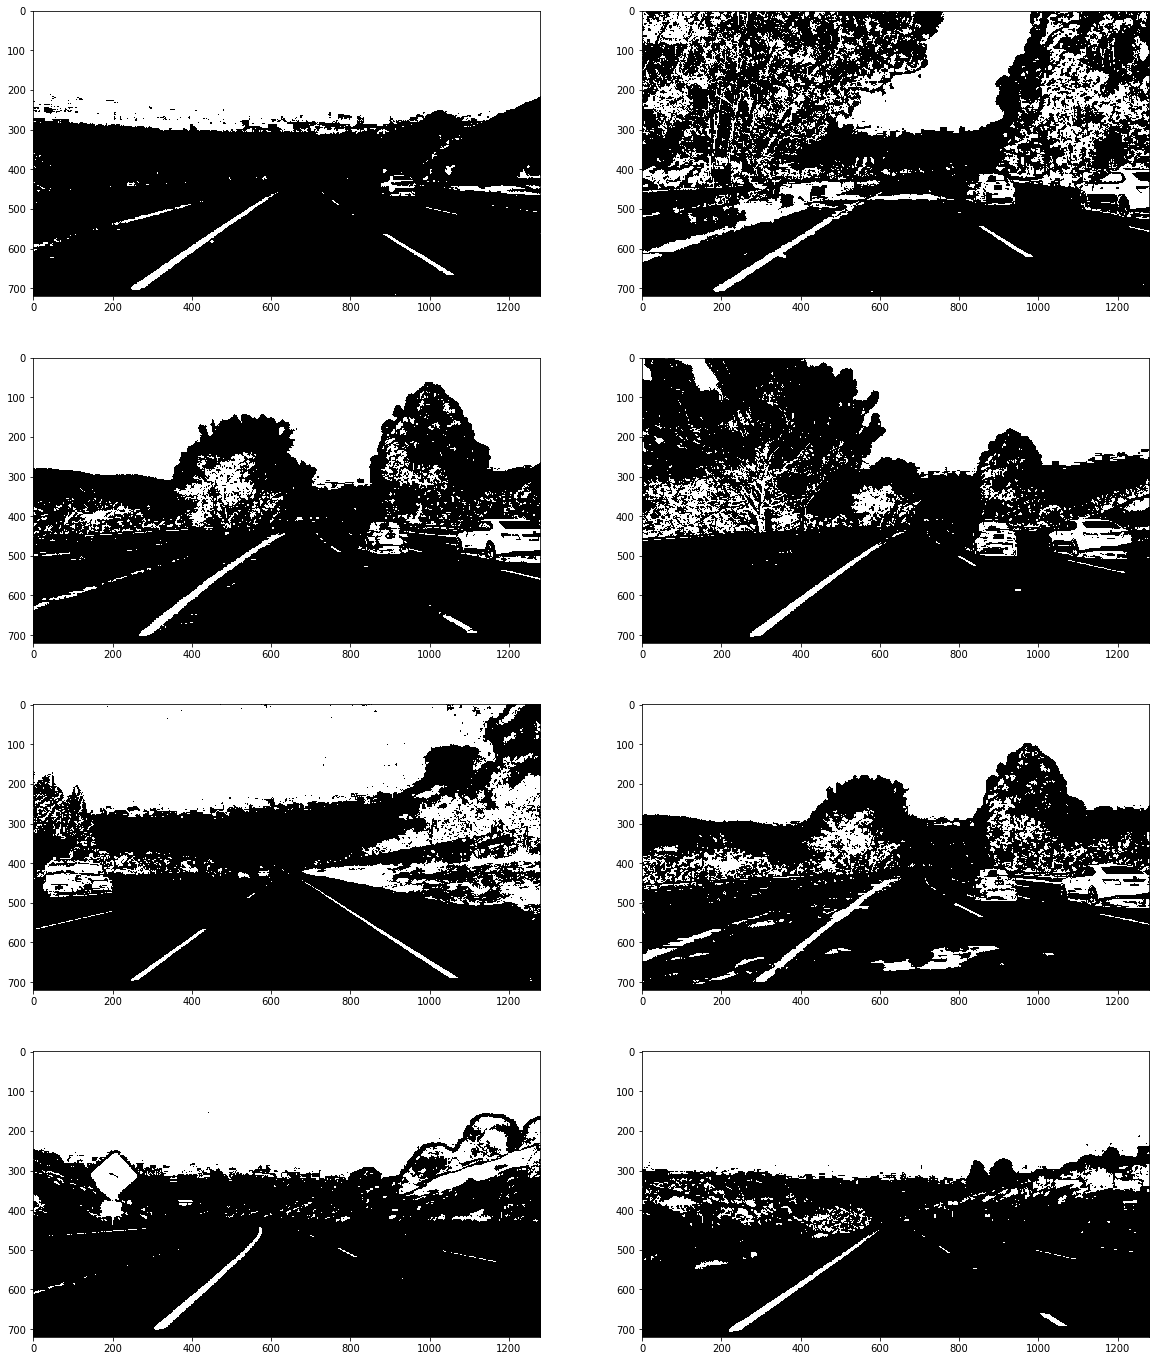

In [43]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
for i in range(0, test_length):

    img_name = test_set[i].split('/')[1]
    
    img, img_size = read_video(test_set[i])
    result = undistort_img(img, process_cam.objpoints, process_cam.imgpoints)
    
    merg = filter_image(result)
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(merg, cmap='gray', interpolation='none')
    
    savepath = os.path.join('output_images', 'filtered_' + img_name)
    imwrite(savepath, merg)

# Run on Test

In [44]:
test_set = glob.glob(test_cases + '/*.jpg')

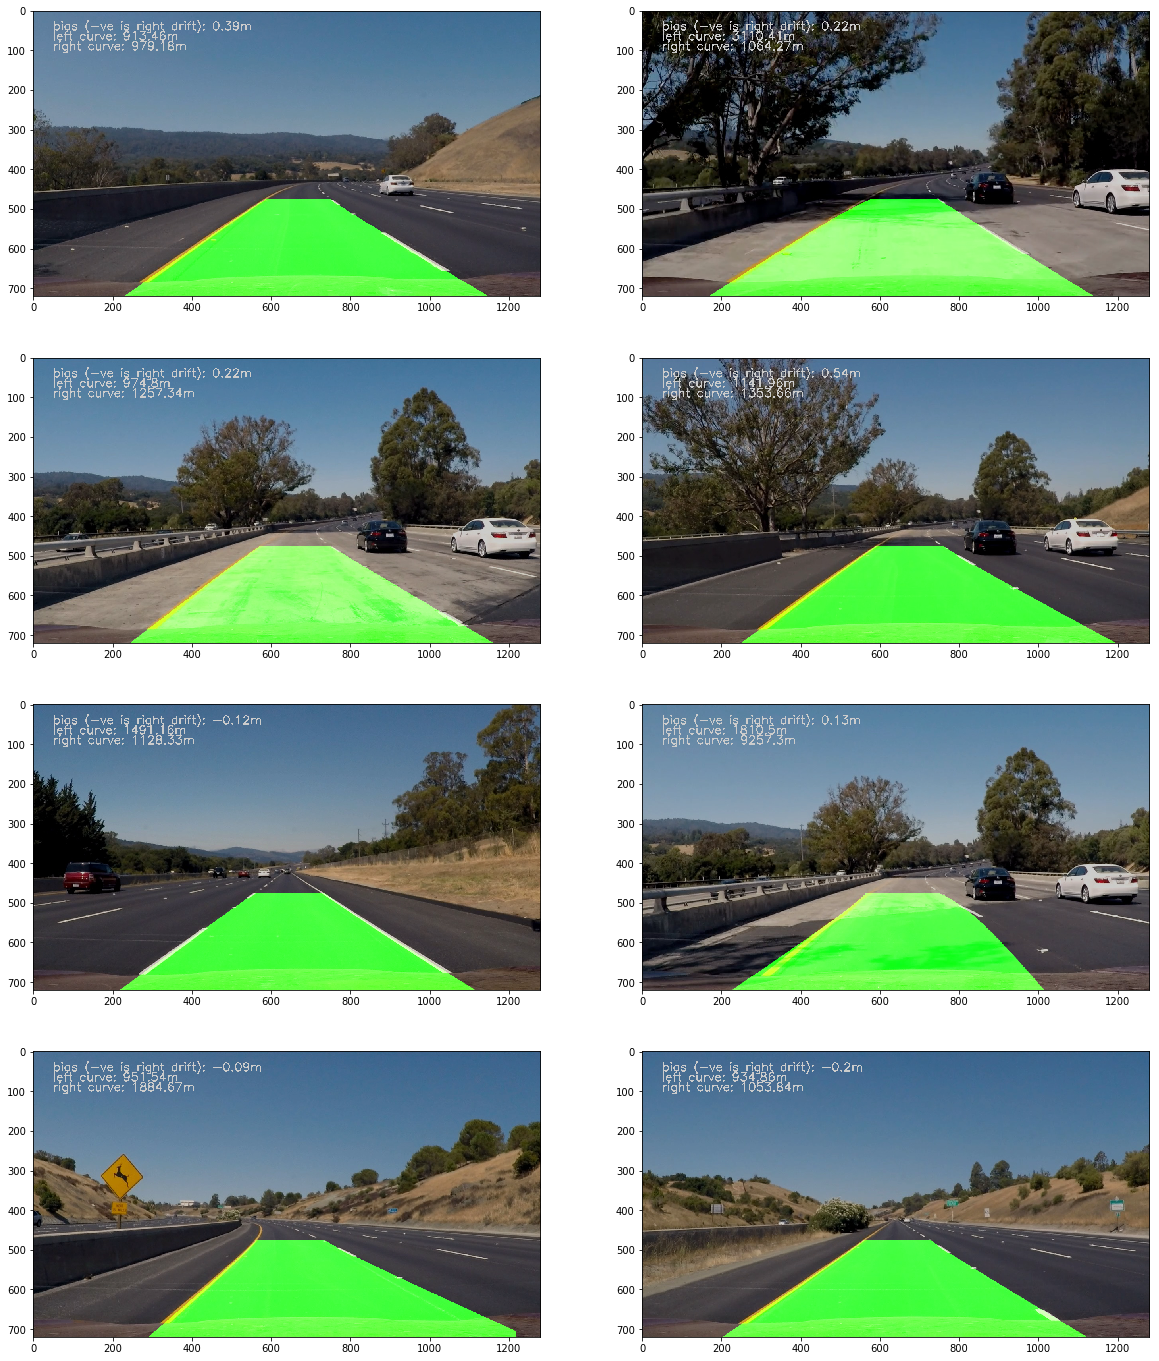

In [45]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
for i in range(0, test_length):
    #logger.info(print(test_pack[i]))
    img_name = test_set[i].split('/')[1]
    
    result = process_cam.process(test_set[i], 0)    
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(result, cmap='gray', interpolation='none')
    
    savepath = os.path.join('output_images', 'final_' + img_name)
    imwrite(savepath, merg.astype(np.uint8))

# Test on Video

In [46]:
def process_image(image):
    result = process_cam.process(image)
    return result

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
output = 'project_processed_video.mp4'
clip = VideoFileClip('project_video.mp4')

In [49]:
test = process_cam.process('project_video.mp4')    

In [50]:
image_clip = clip.fl_image(process_image)
%time image_clip.write_videofile(output, audio=False)

t:   0%|          | 2/1260 [00:00<01:09, 18.10it/s, now=None]

Moviepy - Building video project_processed_video.mp4.
Moviepy - Writing video project_processed_video.mp4



Moviepy - Done !
Moviepy - video ready project_processed_video.mp4
CPU times: user 18min 12s, sys: 3.36 s, total: 18min 16s
Wall time: 2min 13s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))